In [ ]:
!pip uninstall -y keras
!pip uninstall -y tensorflow
!pip install tensorflow>=2.7.0
!pip install keras
!pip install imgviz
!pip install labelme

Found existing installation: keras 2.12.0
Uninstalling keras-2.12.0:
  Successfully uninstalled keras-2.12.0
Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 57.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 115.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!git clone https://github.com/wkentaro/labelme

Cloning into 'labelme'...
remote: Enumerating objects: 7903, done.
remote: Counting objects: 100% (318/318), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 7903 (delta 192), reused 231 (delta 141), pack-reused 7585
Receiving objects: 100% (7903/7903), 45.22 MiB | 23.57 MiB/s, done.
Resolving deltas: 100% (4762/4762), done.


In [ ]:
%cd /content
!mkdir /content/pretrain
%cd /content/pretrain
!gdown --id 1NqhWAg4S298FFfeTMajpaq8jMZ6AecYd

/content
/content/pretrain
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1NqhWAg4S298FFfeTMajpaq8jMZ6AecYd
To: /content/pretrain/model-046.h5
100% 1.43M/1.43M [00:00<00:00, 181MB/s]


In [ ]:
%cd /content
%mkdir Lane_3
!unrar x "/content/drive/MyDrive/Data_Label/Data_03/Lane_3.rar" "/content/Lane_3"

/content

UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from /content/drive/MyDrive/Data_Label/Data_03/Lane_3.rar

Creating    /content/Lane_3/Lane_3                                    OK
Creating    /content/Lane_3/Lane_3/Lane3                              OK
Creating    /content/Lane_3/Lane_3/Lane3/img                          OK
Extracting  /content/Lane_3/Lane_3/Lane3/img/lane_100.jpg                  0%  OK 
Extracting  /content/Lane_3/Lane_3/Lane3/img/lane_1000.jpg                 0%  OK 
Extracting  /content/Lane_3/Lane_3/Lane3/img/lane_10000.jpg                0%  OK 
Extracting  /content/Lane_3/Lane_3/Lane3/img/lane_10010.jpg                0%  OK 
Extracting  /content/Lane_3/Lane_3/Lane3/img/lane_10020.jpg                0%  OK 
Extracting  /content/Lane_3/Lane_3/Lane3/img/lane_10030.jpg                0%  OK 
Extracting  /content/Lane_3/Lane_3/Lane3/img/lane_10040.jpg              

In [ ]:
%cd /content/labelme/examples/semantic_segmentation
!rm -rf /content/Lane_results_3
!python labelme2voc.py /content/Lane_3/Lane_3/Lane3/label /content/Lane_results_3 --labels /content/labels.txt

/content/labelme/examples/semantic_segmentation
Creating dataset: /content/Lane_results_3
Traceback (most recent call last):
  File "/content/labelme/examples/semantic_segmentation/labelme2voc.py", line 106, in <module>
    main()
  File "/content/labelme/examples/semantic_segmentation/labelme2voc.py", line 44, in main
    for i, line in enumerate(open(args.labels).readlines()):
FileNotFoundError: [Errno 2] No such file or directory: '/content/labels.txt'


In [ ]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
# from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
from keras.models import Model, load_model
from keras.layers import concatenate
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

import os
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
tf.compat.v1.disable_eager_execution()

def create_model(input_shape, pool_size):
    # Create the actual neural network here
    input_img = Input(input_shape, name='img')

    c1_1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
    c1_2 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
    c1 = concatenate([c1_1, c1_2])
    p1 = MaxPooling2D((2, 2)) (c1)

    c2_1 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2_2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = concatenate([c2_1, c2_2])
    p2 = MaxPooling2D((2, 2)) (c2)

    c3_1 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3_2 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = concatenate([c3_1, c3_2])
    p3 = MaxPooling2D((2, 2)) (c3)

    u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (p3)
    u5 = concatenate([u5, c3])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (u5)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c2])
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c1])
    c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (c8)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c8)

    model = Model(inputs=[input_img], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
    model.summary()
    return model

In [ ]:
%cd /content/Lane_results_3

/content/Lane_results_3


In [ ]:
filenames = sorted(glob("JPEGImages/*"))
labelf= sorted(glob("SegmentationClassPNG/*"))

filenames.sort()
labelf.sort()
labels=[]
images=[]

def augment_hsv(im, hgain= 0, sgain=0.5, vgain=0.5):
    # HSV color-space augmentation
    if hgain or sgain or vgain:
        r = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1  # random gains
        hue, sat, val = cv2.split(cv2.cvtColor(im, cv2.COLOR_RGB2HSV))
        dtype = im.dtype  # uint8

        x = np.arange(0, 256, dtype=r.dtype)
        lut_hue = ((x * r[0]) % 180).astype(dtype)
        lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
        lut_val = np.clip(x * r[2], 0, 255).astype(dtype)

        im_hsv = cv2.merge((cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val)))
        cv2.cvtColor(im_hsv, cv2.COLOR_HSV2RGB, dst=im)  # no return needed


#đọc tất cả ảnh
for path in filenames:
    img = cv2.imread(path, 1)
    # augment_hsv(img) if np.random.randint(2) == 1 else 0
    # img = img[200:, :, :]
    img = img[200:, :]
    img = cv2.resize(img, (img.shape[1]//4, img.shape[0]//4))
    img = img/255
    # img = np.expand_dims(img, 2)
    images.append(img)
#đọc tất cả label
for path in labelf:
    mask = plt.imread(path)
    if len(mask.shape) == 3:
      mask = mask[200:, :, 0]
      mask = np.where(mask != 0, 1.0, 0.0)
    else:
      mask = mask[200:, :]

    mask= cv2.resize(mask, (mask.shape[1]//4, mask.shape[0]//4))
    # print(mask.shape)
    mask=mask.reshape(mask.shape[0], mask.shape[1] ,1)
    labels.append(mask)

print(np.array(labels).shape)


(0,)


In [ ]:
import numpy as np
print(np.array(labels).shape)
print(np.array(images).shape)
plt.imshow(np.array(images[0]).reshape(40,160,3))

(0,)
(0,)


IndexError: ignored

In [ ]:
images = np.array(images)
labels = np.array(labels)
images, labels = shuffle(images, labels)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2)

batch_size = 128    #batch size
epochs = 100     #số epochs
pool_size = (2, 2)
input_shape = X_train.shape[1:]
print(input_shape)
model = create_model(input_shape, pool_size)                #Xây dựng model

earlystop = EarlyStopping(patience=10)
datagen = ImageDataGenerator(channel_shift_range=0.2, brightness_range=[0.7,1.3])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',   #điều cần quan tâm là độ chính xác nếu độ chính xác
                                                                 #không tăng thì lr sẽ giảm
                                            patience=3,          #số lượng epoch mà sau đó không cải thiện chương trình sẽ stop
                                            verbose=1,           #có cập nhật và hiển thị trạng thái khi reduce
                                            factor=0.5,          #new_lr=factor*lr
                                            min_lr=1e-6)      #giới hạn lr
checkpoint = ModelCheckpoint('/content/model/model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='auto')
callb=[learning_rate_reduction,checkpoint]

#bắt đầu training
# model = load_model('/content/pretrain/model-046.h5')
!rm -rf /content/model

history = model.fit(X_train, y_train ,  validation_data=(X_val, y_val),
                    epochs=epochs, verbose=1, callbacks=callb)

(40, 160, 3)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 40, 160, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 40, 160, 8)   224         ['img[0][0]']                    
                                                                                                  
 conv2d_40 (Conv2D)             (None, 40, 160, 8)   224         ['img[0][0]']                    
                                                                                                  
 concatenate_18 (Concatenate)   (None, 40, 160, 16)  0           ['conv2d_39[0]

In [ ]:
X_test = cv2.imread('/content/Lane_results/JPEGImages/lane_14400.jpg')
from PIL import Image
from google.colab.patches import cv2_imshow
import os
import cv2
from keras.models import load_model
modeltrain = load_model('/content/Lane_results/weight_mod_gray/model-045.h5')

X_test = X_test[200:, :, :]
X_test = cv2.resize(X_test, (X_test.shape[1]//4, X_test.shape[0]//4))
X_test = np.array(X_test)
X_test = X_test/255
X_test = X_test[None,:,:,:]
predictions = modeltrain.predict(X_test)
print(predictions.shape)

In [ ]:
modeltrain = load_model('/content/model/model-040.h5')
img = cv2.imread('/content/Lane_results_3/JPEGImages/lane_8080.jpg')

print(img.shape)
img = img[200:, :, :]
# img = np.expand_dims(img, 2)

img = cv2.resize(img, (img.shape[1]//4, img.shape[0]//4))
# cv2.imwrite("pre_img.png", img)

img = img/255
img = np.array(img, dtype=np.float32)
print(img.shape)
img = img[None, :, :,:]
pred = modeltrain.predict(img)
pred = np.squeeze(pred)
pred = np.where(pred > 0.5, 255, 0)
pred = pred.astype(np.uint8)
print(pred)
print(np.unique(pred))


(360, 640, 3)
(40, 160, 3)
[[  0 255 255 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0 255 255 ... 255   0   0]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[  0 255]


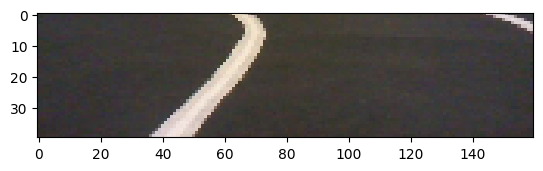

In [ ]:
# img = cv2.imread('/content/Lane_results/JPEGImages/lane_22000.jpg')
plt.imshow(np.array(img).reshape(40,160,3))

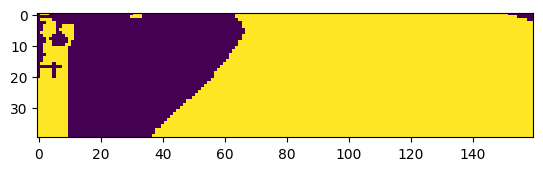

In [ ]:
plt.imshow(np.array(pred).reshape(40,160))


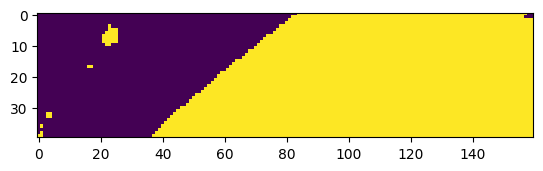

In [ ]:
plt.imshow(np.array(pred).reshape(40,160))


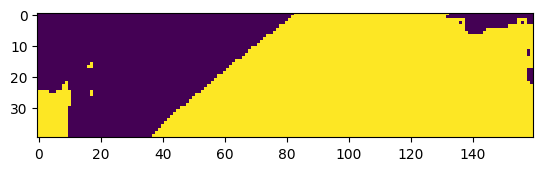

In [ ]:
plt.imshow(np.array(pred).reshape(40,160))